# 22. Clustering Algorithms

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/22.ClusteringAlgorithms.ipynb)

(Taken from https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-05-09-Clustering-with-Scikit-with-GIFs.ipynb with only minor modifications.)

Clustering algorithms can be broadly split into two types, depending on whether the number of segments is explicitly specified by the user. This distinction can sometimes be a little unclear, as some algorithms employ parameters that act as proxies for the number of clusters.

First, we need to load all the required modules in our python script and two toy datasets to illustrate and compare each technique. The significance of each one will hopefully become apparent.

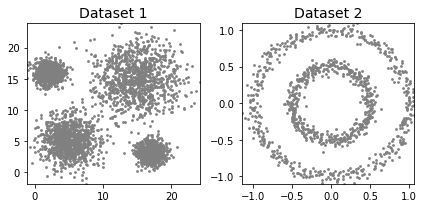

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(844)
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# we take the first array as the second array has the cluster labels
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

# plot clustering output on the two datasets
def cluster_plots(set1, set2, colours1 = 'gray', colours2 = 'gray', 
                  title1 = 'Dataset 1',  title2 = 'Dataset 2'):
    fig,(ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    ax1.set_title(title1,fontsize=14)
    ax1.set_xlim(min(set1[:,0]), max(set1[:,0]))
    ax1.set_ylim(min(set1[:,1]), max(set1[:,1]))
    ax1.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c= colours1)
    ax2.set_title(title2,fontsize=14)
    ax2.set_xlim(min(set2[:,0]), max(set2[:,0]))
    ax2.set_ylim(min(set2[:,1]), max(set2[:,1]))
    ax2.scatter(set2[:, 0], set2[:, 1],s=8,lw=0,c=colours2)
    fig.tight_layout()
    plt.show()

cluster_plots(dataset1, dataset2)

### K-means Clustering

K-means is likely one of the most popular clustering algorithms. The algorithm itself is relatively simple: Starting with a pre-specified number of cluster centroids, each point is initally assigned to its nearest centre. In the next step, for each segment, the centres are moved to the centroid of the clustered points. The points are then reassigned to their nearest centre. The process is repeated until moving the centres derives little or no improvement (measured by the within cluster sum of squares- the total squared distance between each point and its cluster centre). The alogorithm is concisely illustrated by the GIF below.

![title](https://dashee87.github.io/images/kmeans.gif)

K-means clustering in scikit offers several extensions. To prevent the alogrithm returning sub-optimal clustering, the kmeans method includes the `n_init` and `method` parameters. The former just reruns the algorithm with n different initialisations and returns the best output (measured by the within cluster sum of squares). By setting the latter to 'kmeans++' (the default), the initial centres are smartly selected (i.e. better than random). This has the additional benefit of decreasing runtime (less steps to reach convergence).

Dataset1
Cluster 0: 1008
Cluster 1: 952
Cluster 2: 1022
Cluster 3: 1018


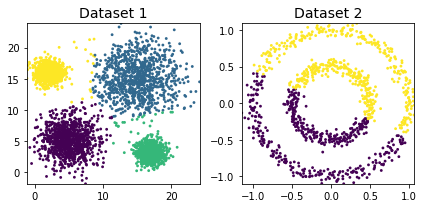

In [2]:
# implementing k-means clustering
kmeans_dataset1 = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(dataset1)
kmeans_dataset2 = cluster.KMeans(n_clusters=2, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(dataset2)
print('Dataset1')
print(*["Cluster "+str(i)+": "+ str(sum(kmeans_dataset1==i)) for i in range(4)], sep='\n')
cluster_plots(dataset1, dataset2, 
              kmeans_dataset1, kmeans_dataset2)

K-means performs well on Dataset1, but fails on Dataset2. In fact, these two datasets illustrate the strenghts and weaknesses of k-means. The algorithm seeks and identifies globular (essentially spherical) clusters. If this assumption does not hold, the model output may be inadaquate (or just really bad). K-means also underperforms with clusters of different size and density.

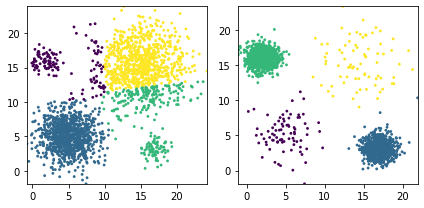

In [3]:
kmeans_dataset1 = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(np.vstack([dataset1[:2080,:],
                                                                                    dataset1[3000:3080,:]]))
kmeans_dataset2 = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(np.vstack([dataset1[-2080:,],
                                                                                    dataset1[:80,]]))
cluster_plots(np.vstack([dataset1[:2080,],dataset1[3000:3080,]]), 
              np.vstack([dataset1[-2080:,],dataset1[:80,]]), 
              kmeans_dataset1, kmeans_dataset2,title1='', title2='')

For all its faults, the enduring popularity of k-means (and related algorithms) stems from its versatility. Its average complexity is O(k*n*T), where k,n and T are the number of clusters, samples and iterations, respectively. As such, it's considered one of the [fastest clustering algorithms out there](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). And in the world of big data, this matters. If your boss wants 10 customer segments by close of business, then you'll probably use k-means and just hope no one knows the word [globular](https://www.merriam-webster.com/dictionary/globular). 

# Expectation Maximisation (EM)

This technique is the application of the [general expectation maximisation (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) to the task of clustering. It is conceptually related and visually similar to k-means (see GIF below). Where k-means seeks to minimise the distance between the observations and their assigned centroids, EM estimates some latent variables (typically the mean and covariance matrix of a mutltinomial normal distribution (called [Gaussian Mixture Models (GMM)](http://scikit-learn.org/stable/modules/mixture.html))), so as to maximise the log-likelihood of the observed data. Similar to k-means, the algorithm converges to the final clustering by iteratively improving its performance (i.e. reducing the log-likelihood). However, again like k-means, there is no guarantee that the algorithm has settled on the global minimum rather than local minimum (a concern that increases in higher dimensions).

![title](https://dashee87.github.io/images/em_only.gif)

In contrast to kmeans, observations are not explicitly assigned to clusters, but rather given probabilities of belonging to each distribution. If the underlying distribution is correctly identified (e.g. normal distribution in the GIF), then the algorithm performs well. In practice, especially for large datasets, the underlying distribution may not be retrievble, so EM clustering may not be well suited to such tasks.

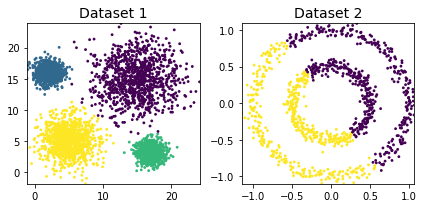

In [4]:
# implementing Expecation Maximistation (specifically Guassian Mixture Models)
em_dataset1 = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(dataset1)
em_dataset2 = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(dataset2)
cluster_plots(dataset1, dataset2, em_dataset1.predict(dataset1),  em_dataset2.predict(dataset2))

No surprises here. EM clusters the first dataset perfectly, as the underlying data is normally distributed. In contrast, `Dataset2` cannot be accurately modelled as a GMM, so that's why EM performs so poorly in this case.

# Hierarchical Clustering

Unlike k-means and EM, [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) (HC) doesn't require the user to specify the number of clusters beforehand. Instead it returns an output (typically as a dendrogram- see GIF below), from which the user can decide the appropriate number of clusters (either manually or [algorithmically](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)). If done manually, the user may cut the dendrogram where the merged clusters are too far apart (represented by a long lines in the dendrogram). Alternatively, the user can just return a specific number of clusters (similar to k-means).

![title](https://dashee87.github.io/images/hierarch.gif)

As its name suggests, it constructs a hierarchy of clusters based on proximity (e.g Euclidean distance or Manhattan distance- see GIF below). HC typically comes in two flavours (essentially, bottom up or top down): 

* Divisive: Starts with the entire dataset comprising one cluster that is iteratively split- one point at a time- until each point forms its own cluster.
* Agglomerative: The agglomerative method in reverse- individual points are iteratively combined until all points belong to the same cluster.

Another important concept in HC is the linkage criterion. This defines the distance between clusters as a function of the points in each cluster and determines which clusters are merged/split at each step. That clumsy sentence is neatly illustrated in the GIF below.

![title](https://dashee87.github.io/images/hierarch_1.gif)

Dataset 1
Cluster 0: 990
Cluster 1: 1008
Cluster 2: 1002
Cluster 3: 1000


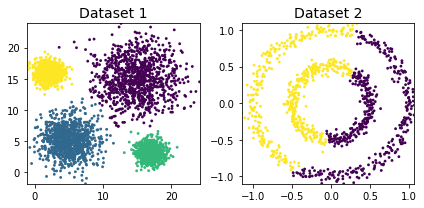

In [5]:
# implementing agglomerative (bottom up) hierarchical clustering
# we're going to specify that we want 4 and 2 clusters, respectively
hc_dataset1 = cluster.AgglomerativeClustering(n_clusters=4, affinity='euclidean', 
                                              linkage='ward').fit_predict(dataset1)
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                              linkage='average').fit_predict(dataset2)
print("Dataset 1")
print(*["Cluster "+str(i)+": "+ str(sum(hc_dataset1==i)) for i in range(4)], sep='\n')
cluster_plots(dataset1, dataset2, hc_dataset1, hc_dataset2)

You may notice that HC does not perform so well on the noisy circles.

However, by imposing simple connectivity constraints (points can only cluster with their n(=5) nearest neighbours), HC can capture the non-globular structures within the dataset.

/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:476: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


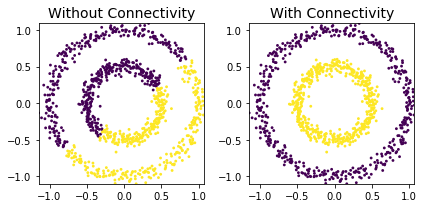

In [7]:
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                              linkage='complete').fit_predict(dataset2)
connect = kneighbors_graph(dataset2, n_neighbors=5, include_self=False)

hc_dataset2_connectivity = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                              linkage='complete',connectivity=connect).fit_predict(dataset2)
cluster_plots(dataset2, dataset2,hc_dataset2,hc_dataset2_connectivity,
             title1='Without Connectivity', title2='With Connectivity')